# Report on Statistical Clear Sky Fitting Algorithm
    
This algorithm takes as input the power signal (as a function of time of the day and day of the year) and outputs the power signal which would have been obtained for clear sky (CS) conditions (i.e. absence of visible clouds in a given location). Under the hood this method uses a generalized low-rank fitting algorithm. The clear-sky power signal obtained this way can be used to normalize the observed power signal (i.e. observed power / clear-sky power).


## Resources
- [The paper describing the mathematics of the model](https://arxiv.org/pdf/1907.08279.pdf)
- [The paper explaining how the degradation is estimated in the model](https://arxiv.org/abs/1907.09456)
- [github](https://github.com/slacgismo/StatisticalClearSky)

The statistical_clear_sky package requires solardatatools, cvxpy <= 1.0.31, and mosek solver (which is available with an academic license)

## Brief summary 

Clear Sky Statistical Model has managed to create a rather good clear-sky model (for basic, soiling, and soiling+weather signals). In particular, it was able to remove soiling and weather paterns from the signal.
Hence the method could be used to noramlise the the power output. The only disdvatages of this method is a long time required to process a single signal (around 30mins for a 5yr signal) and it is relatively hard to set the package up. In particular, it requres mosek license. 

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Replace sample_func_dir by the name of directory in src/ and replace sample_func_file the
# file name in src/sample_func_dir
from src.data.import_data import *
from src.data.make_dataset import *
import numpy as np
import pickle
import matplotlib.pyplot as plt

from solardatatools import make_2d

# There is some weird error if numpy is imported before SCFM…
# It also requires a mosek license
from statistical_clear_sky.algorithm.iterative_fitting import *

# A signal from the basic dataset

In [2]:
# Load the data
index           = 1
path_to_zip_pkl = '../data/raw/synthetic_basic.zip'
df              = import_df_from_zip_pkl(path_to_zip_pkl, index=index)

# Load the actual degradation rate
df_info = import_df_info_from_zip("../data/raw/synthetic_basic.zip")
actual_deg = df_info.Degradation_rate_linear.iloc[1]

In [3]:
df.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,0
2015-01-01 00:01:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,1
2015-01-01 00:02:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,2
2015-01-01 00:03:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,3
2015-01-01 00:04:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2629440 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 23:59:00-05:00
Freq: T
Data columns (total 8 columns):
Power            float64
POA              float64
Tamb             float64
Wind             float64
Degradation      float64
Soiling          int64
Faults           int64
minute_of_day    int64
dtypes: float64(5), int64(3)
memory usage: 180.5 MB


First convert the DataFrame into a 2-dimensional signal of the form $Power(\text{minute_of_day}, \text{day_of_year})$. However, we can not apply clipping removing on this data.

The function `make_2d` seems to discard the first and the last day of the DataFrame given to it by default.

In [5]:
signal_2d = make_2d(df[df.index.year <= 2017], key="Power", trim_start=False, trim_end=False)
signal_2d.shape

(1440, 1096)

The computation takes quite a long time. For example, simply to considering a single 3 year power singal, the algorithm take around 15mins

In [6]:
scsf = IterativeFitting(signal_2d)
scsf.execute(is_degradation_calculated=False)
clear_sky_signals = scsf.clear_sky_signals()

obtaining weights
obtaining initial value of component r0
Starting at Objective: 6.033e+06, f1: 9.678e+05, f2: 2.145e+00, f3: 2.216e+05, f4: 4.844e+06
    Minimizing left matrix
    Minimizing right matrix
Minimize R status: infeasible
Starting over and reversing minimization order.
obtaining initial value of component r0
    Minimizing right matrix
    Minimizing left matrix
1 - Objective: 3.342e+06, f1: 3.194e+06, f2: 6.607e+01, f3: 1.483e+05, f4: 4.573e-05
Caution: residuals increased
    Minimizing right matrix
    Minimizing left matrix
2 - Objective: 2.059e+06, f1: 1.913e+06, f2: 6.941e+01, f3: 1.454e+05, f4: 3.141e-05
Caution: residuals increased
    Minimizing right matrix
    Minimizing left matrix
3 - Objective: 1.263e+06, f1: 1.117e+06, f2: 4.965e+01, f3: 1.463e+05, f4: 4.480e-06
Caution: residuals increased
    Minimizing right matrix
    Minimizing left matrix
4 - Objective: 1.058e+06, f1: 9.093e+05, f2: 4.022e+01, f3: 1.491e+05, f4: 1.656e-05
    Minimizing right matrix
 

In [7]:
pickle.dump(scsf, open("scsf_basic_1_no_deg_3yr.p", "wb" ))

The tool provides a few plotting functions out of the box

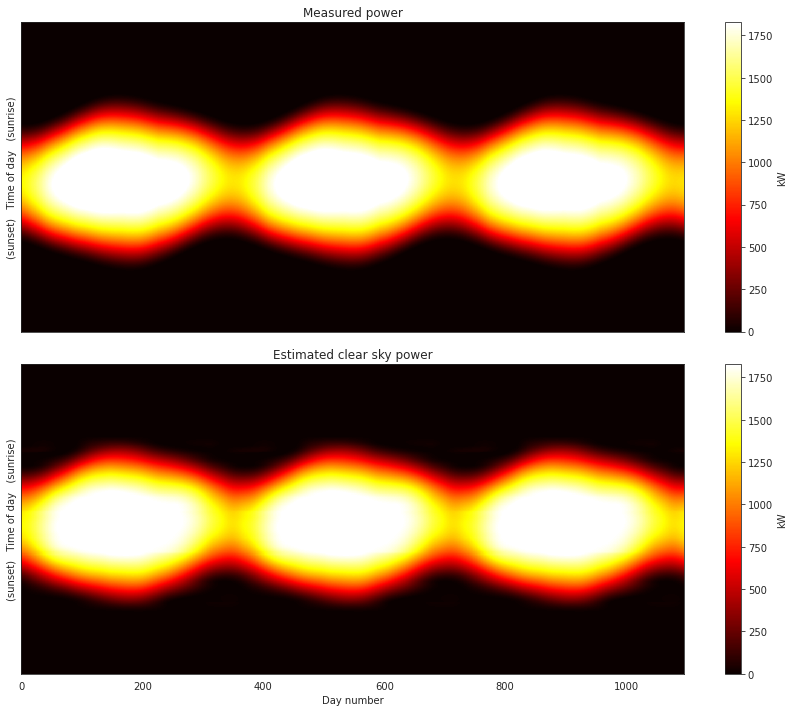

In [8]:
scsf.plot_measured_clear_matrices()
print()

Text(0, 0.5, 'Energy')

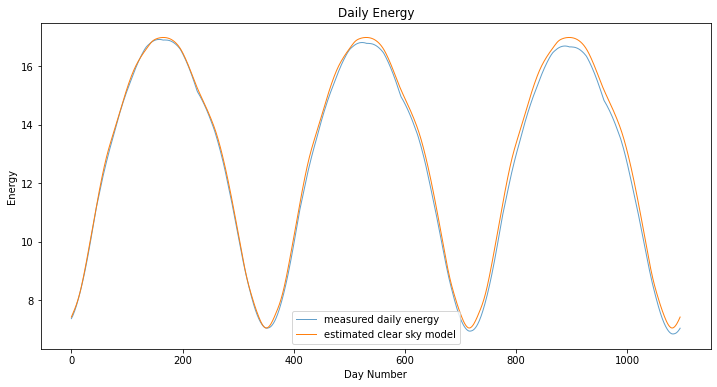

In [9]:
scsf.plot_energy(show_clear=True, show_days=False, scale_power=True)
plt.title('Daily Energy')
plt.xlabel('Day Number')
plt.ylabel('Energy')

Next, create `cs_df` a DataFrame which holds the power obtained by the clear sky statistical fitting algorithm.

In [10]:
sdf = df[df.index.year <= 2017]
cs_df = pd.DataFrame(index = sdf.index)
cs_df['Power'] = np.reshape(np.transpose(clear_sky_signals), 1440*1096)
cs_df['minute_of_day'] = cs_df.index.hour * 60 + cs_df.index.minute
cs_df['Faults'] = np.nan
cs_df['Soiling'] = np.nan
cs_df['Degradation'] = np.nan

/home/julius/Aug20_Epri/.env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Text(0, 0.5, 'Power (kW)')

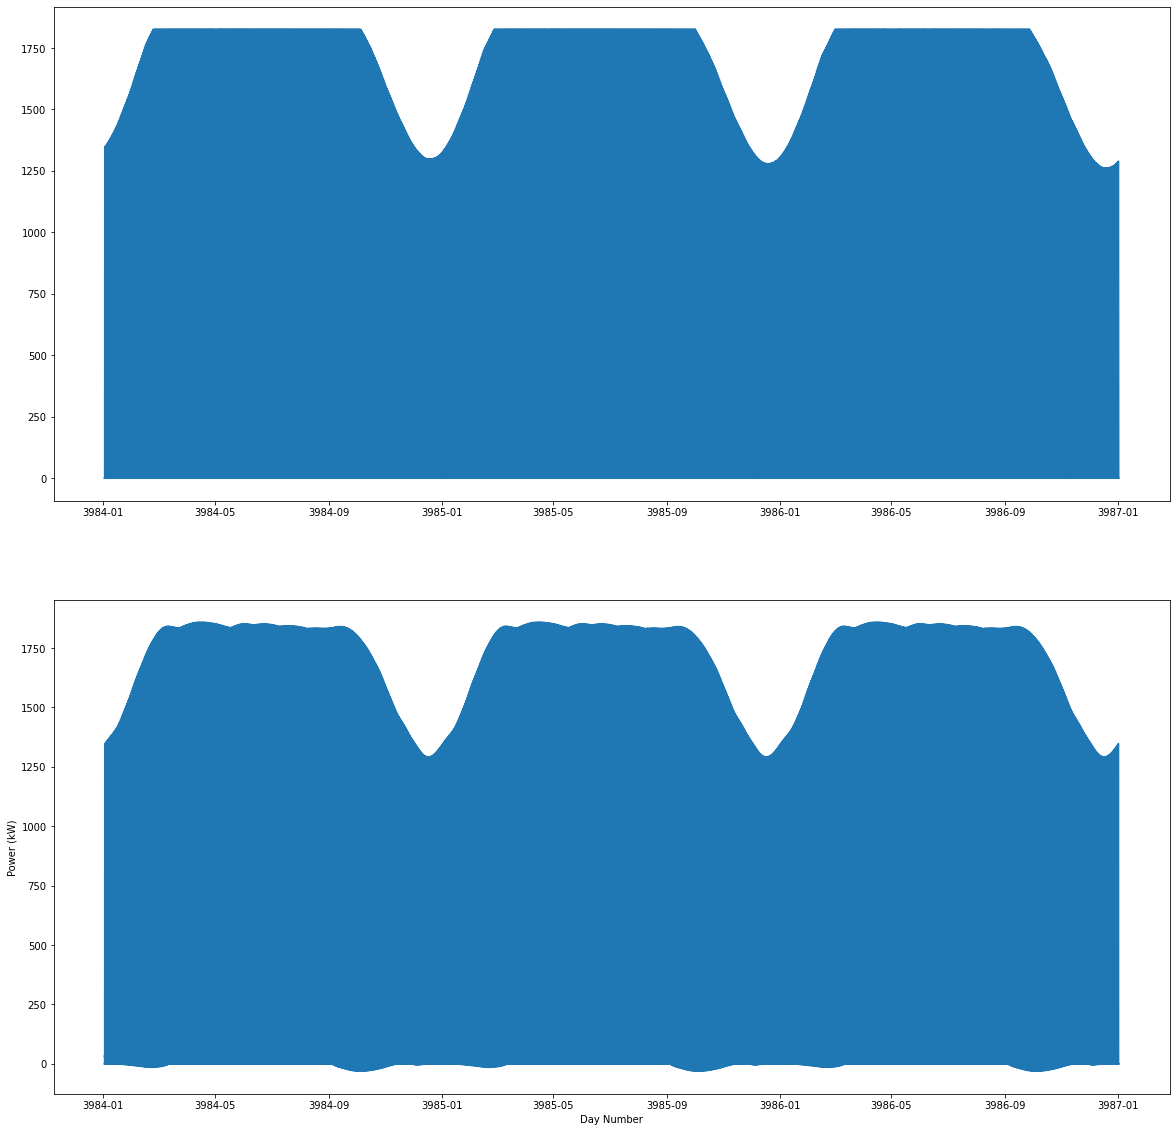

In [11]:
_, axs = plt.subplots(2, 1, figsize=(20, 20))

axs[0].plot(sdf.Power)
axs[1].plot(cs_df.Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Compare the two signals using our downsampling with and without removal of data

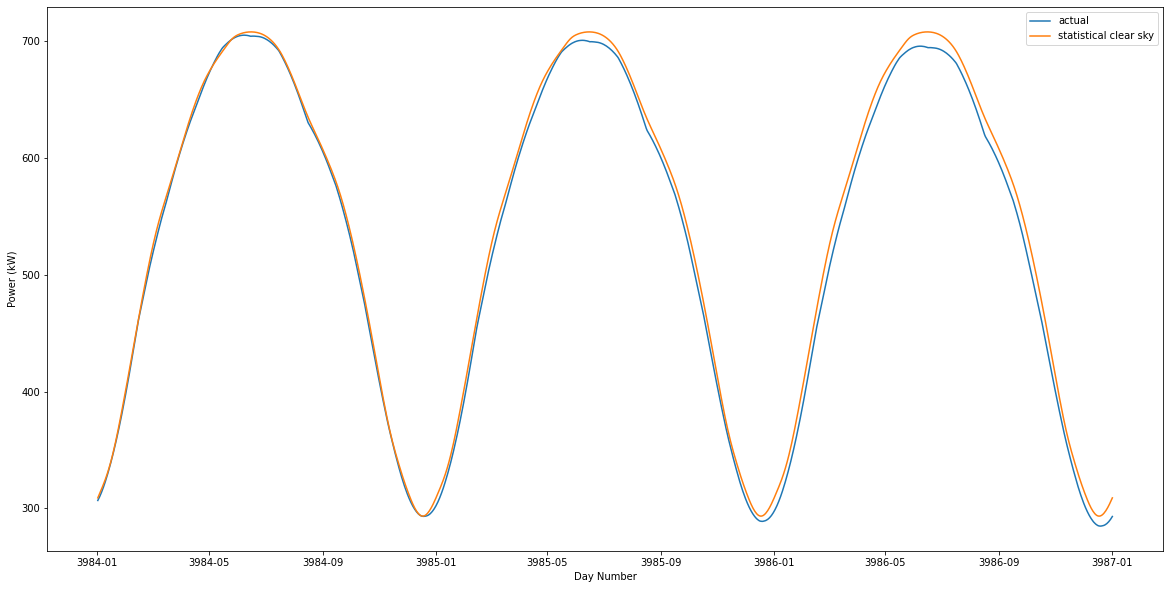

In [12]:
# Without clipping removal
_, ax = plt.subplots(figsize=(20, 10))

ax.plot(downsample_dataframe(sdf).Power, label = "actual")
ax.plot(downsample_dataframe(cs_df).Power, label = "statistical clear sky")
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')
plt.legend()

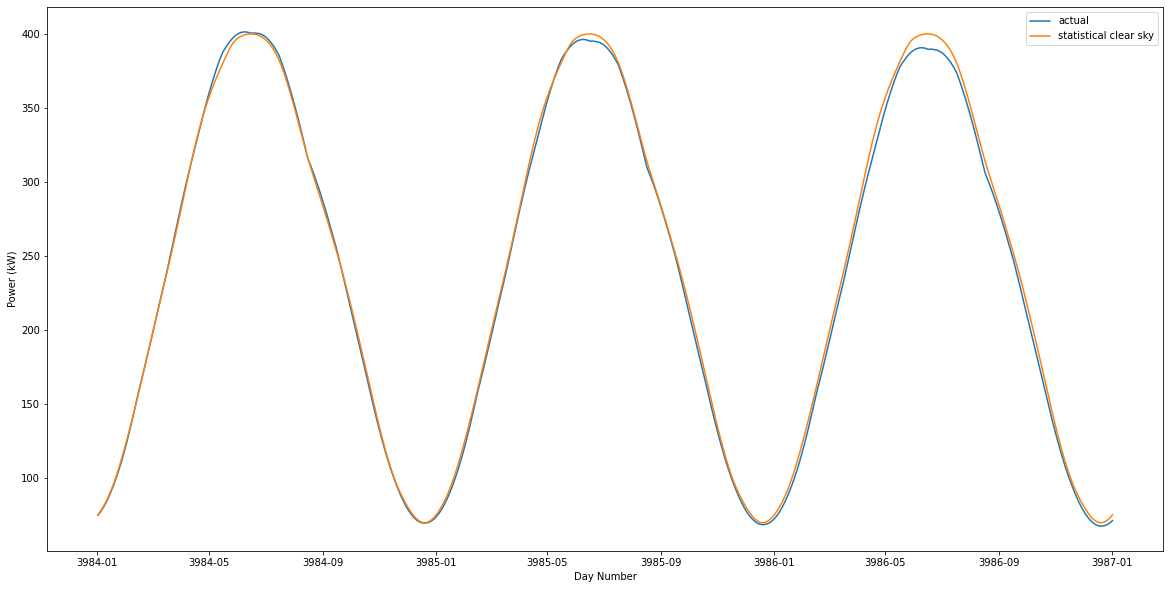

In [13]:
# With clipping removal
sdf_processed = remove_clipping_with_universal_window(sdf, max_power=1800)
sdf_processed = downsample_dataframe(sdf_processed)
cs_df_processed = remove_clipping_with_universal_window(cs_df, max_power=1800)
cs_df_processed = downsample_dataframe(cs_df_processed)

_, ax = plt.subplots(figsize=(20, 10))

ax.plot(sdf_processed.Power, label = "actual")
ax.plot(cs_df_processed.Power, label = "statistical clear sky")
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')
plt.legend()

Text(0, 0.5, 'Factor')

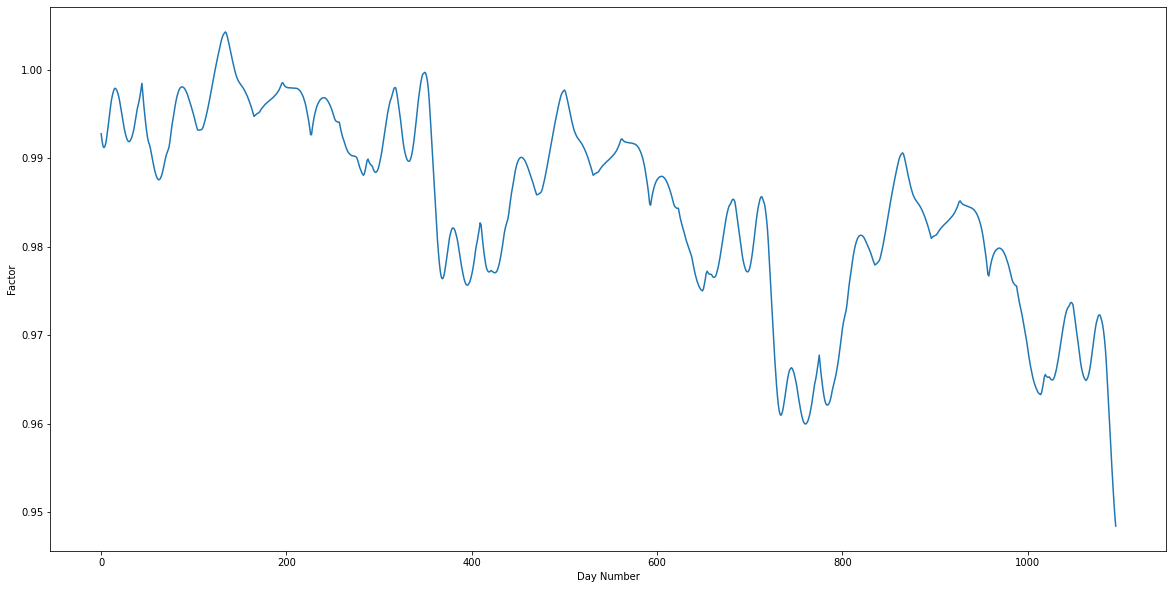

In [14]:
# Normalised power
norm_power = downsample_dataframe(sdf).Power.to_numpy() / downsample_dataframe(cs_df).Power.to_numpy()

_, ax = plt.subplots(figsize=(20,10))
ax.plot(norm_power)
plt.xlabel('Day Number')
plt.ylabel('Factor')

In [15]:
# Fit a line to the normalised power
rd, _ = np.polyfit(np.arange(len(norm_power)), norm_power, deg = 1)
print(f"Predicted degradation is {rd*365*100:0.3f}%/year, while the actual degradation is {actual_deg*100:0.3f}%/year")

Predicted degradation is -0.941%/year, while the actual degradation is -1.371%/year


# A signal from the soil dataset

We repeat the above steps for one of the signals from the soiling dataset

In [16]:
# Load the data
index           = 1
path_to_zip_pkl = '../data/raw/synthetic_soil.zip'
df              = import_df_from_zip_pkl(path_to_zip_pkl, index=index, verbose=True)

# Load the actual degradation rate
df_info = import_df_info_from_zip("../data/raw/synthetic_soil.zip", verbose=True)
actual_deg = df_info.Degradation_rate_linear.iloc[1]


importing synthetic_soil/synthetic_soil_002.pkl

time for importing dataframe: 0.73 seconds
Found the following dataset info-files  ['synthetic_soil/synthetic_soil_info.csv']

importing synthetic_soil/synthetic_soil_info.csv



In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2629440 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 23:59:00-05:00
Freq: T
Data columns (total 8 columns):
Power            float64
POA              float64
Tamb             float64
Wind             float64
Degradation      float64
Soiling          float64
Faults           int64
minute_of_day    int64
dtypes: float64(6), int64(2)
memory usage: 180.5 MB


In [18]:
df.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,0
2015-01-01 00:01:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,1
2015-01-01 00:02:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,2
2015-01-01 00:03:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,3
2015-01-01 00:04:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,4


Convet the signal into a 2-dimentional matrix

In [19]:
signal_2d = make_2d(df[df.index.year <= 2017], key="Power", trim_start=False, trim_end=False)
signal_2d.shape

(1440, 1096)

Run the algorithm 

In [20]:
scsf = IterativeFitting(signal_2d)
scsf.execute(is_degradation_calculated=False)
clear_sky_signals = scsf.clear_sky_signals()

obtaining weights
obtaining initial value of component r0
Starting at Objective: 2.740e+07, f1: 1.285e+06, f2: 1.769e+00, f3: 9.153e+06, f4: 1.696e+07
    Minimizing left matrix
    Minimizing right matrix
1 - Objective: 4.323e+06, f1: 4.100e+06, f2: 3.436e+01, f3: 2.235e+05, f4: 1.362e-04
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 2.748e+06, f1: 2.531e+06, f2: 3.847e+01, f3: 2.173e+05, f4: 1.761e-04
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 2.410e+06, f1: 2.185e+06, f2: 3.165e+01, f3: 2.257e+05, f4: 5.632e-05
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 2.283e+06, f1: 2.059e+06, f2: 3.398e+01, f3: 2.239e+05, f4: 8.363e-05
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
5 - Objective: 2.237e+06, f1: 2.011e+06, f2: 3.139e+01, f3: 2.259e+05, f4: 4.970e-05
Caution: residuals increased
    

In [21]:
pickle.dump(scsf, open("scsf_soil_1_no_deg_3yr.p", "wb" ))

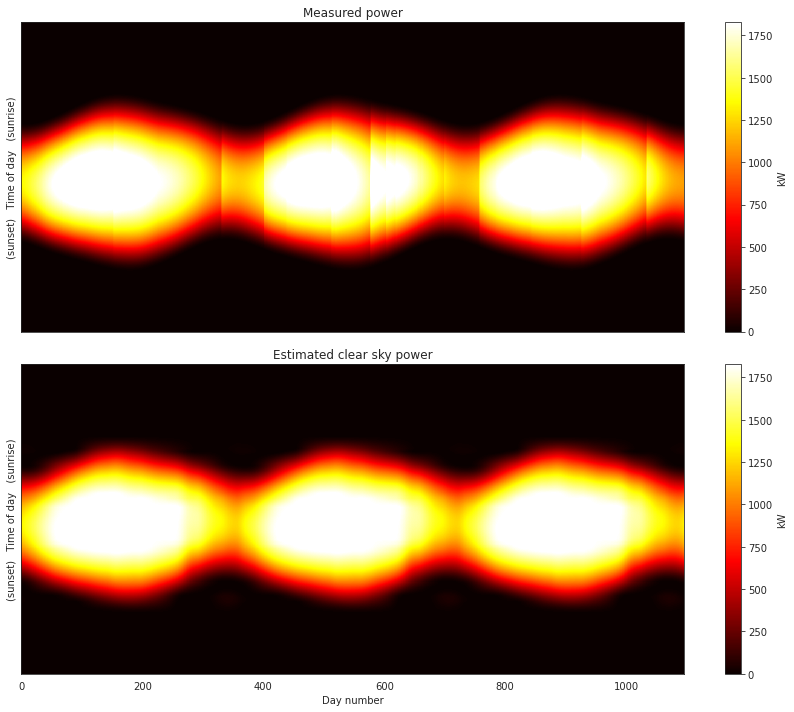

In [22]:
scsf.plot_measured_clear_matrices()
print()

Text(0, 0.5, 'Power (kW)')

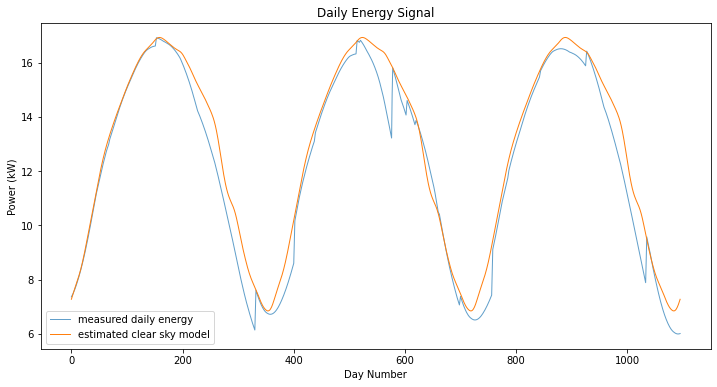

In [23]:
scsf.plot_energy(show_clear=True, show_days=False, scale_power=True)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Next, create `cs_df` a DataFrame which holds the power obtained by the clear sky statistical fitting algorithm.

In [24]:
sdf = df[df.index.year <= 2017]
cs_df = pd.DataFrame(index = sdf.index)
cs_df['Power'] = np.reshape(np.transpose(clear_sky_signals), 1440*1096)
cs_df['minute_of_day'] = cs_df.index.hour * 60 + cs_df.index.minute
cs_df['Faults'] = np.nan
cs_df['Soiling'] = np.nan
cs_df['Degradation'] = np.nan

Plot the power versus time for the actual and modeled outputs

/home/julius/Aug20_Epri/.env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Text(0, 0.5, 'Power (kW)')

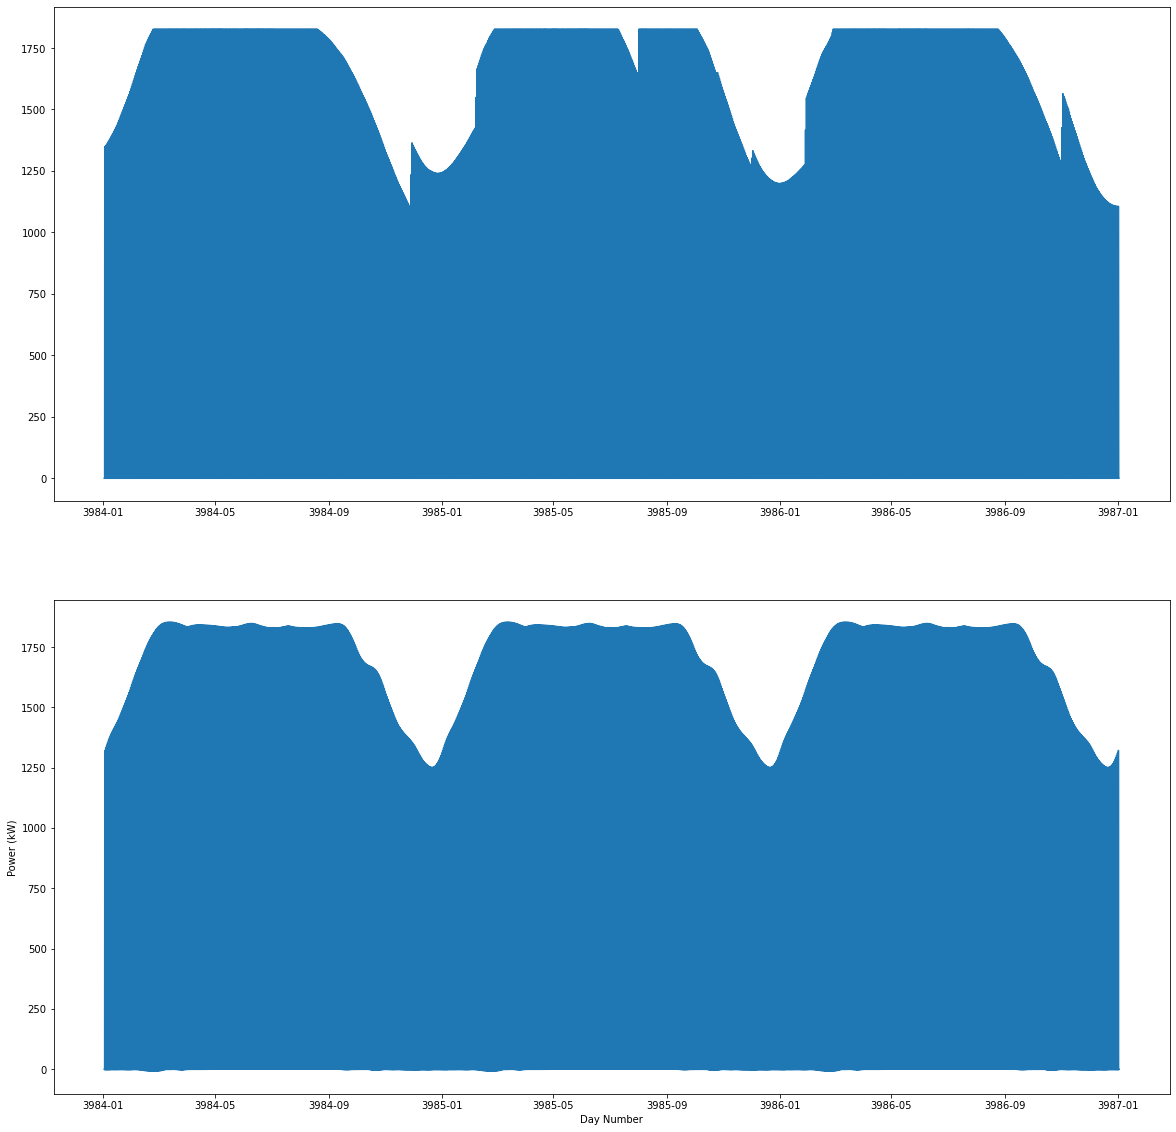

In [25]:
_, axs = plt.subplots(2, 1, figsize=(20, 20))

axs[0].plot(sdf.Power)
axs[1].plot(cs_df.Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Compare the two signals using our downsampling with and without removal of data.

First, start without removing any data

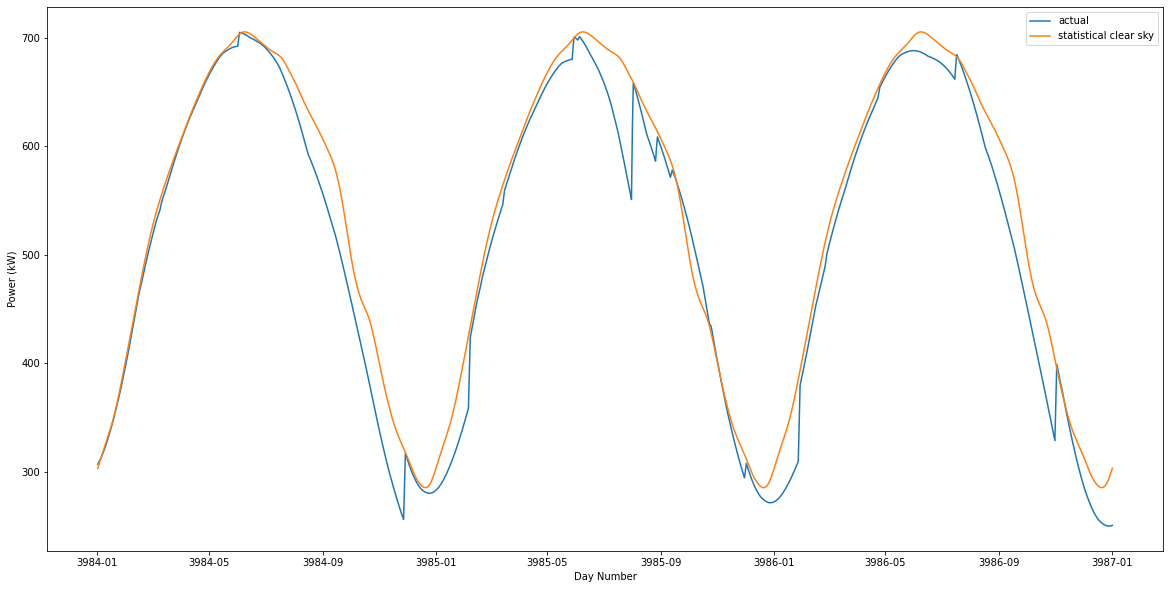

In [26]:
# Without clipping removal
_, ax = plt.subplots(figsize=(20, 10))

ax.plot(downsample_dataframe(sdf).Power, label = "actual")
ax.plot(downsample_dataframe(cs_df).Power, label = "statistical clear sky")
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')
plt.legend()

Remove clipping using universal window and clipping power set to 1800. Note that removing the night data might not work, since the clear sky does not have value -1 for the night signal.

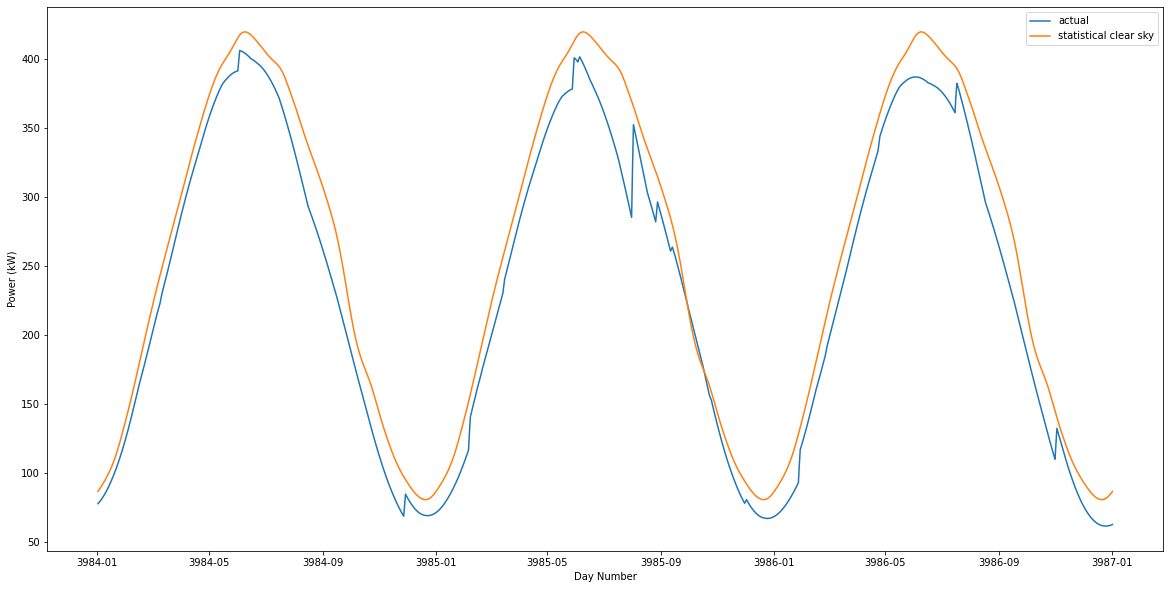

In [27]:
# With clipping removal
sdf_processed = remove_clipping_with_universal_window(sdf, max_power=1800)
sdf_processed = downsample_dataframe(sdf_processed)
cs_df_processed = remove_clipping_with_universal_window(cs_df, max_power=1800)
cs_df_processed = downsample_dataframe(cs_df_processed)

_, ax = plt.subplots(figsize=(20, 10))

ax.plot(sdf_processed.Power, label = "actual")
ax.plot(cs_df_processed.Power, label = "statistical clear sky")
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')
plt.legend()

Finally, let's consider the normalised power signal (without removal of clipping)

Text(0, 0.5, 'Factor')

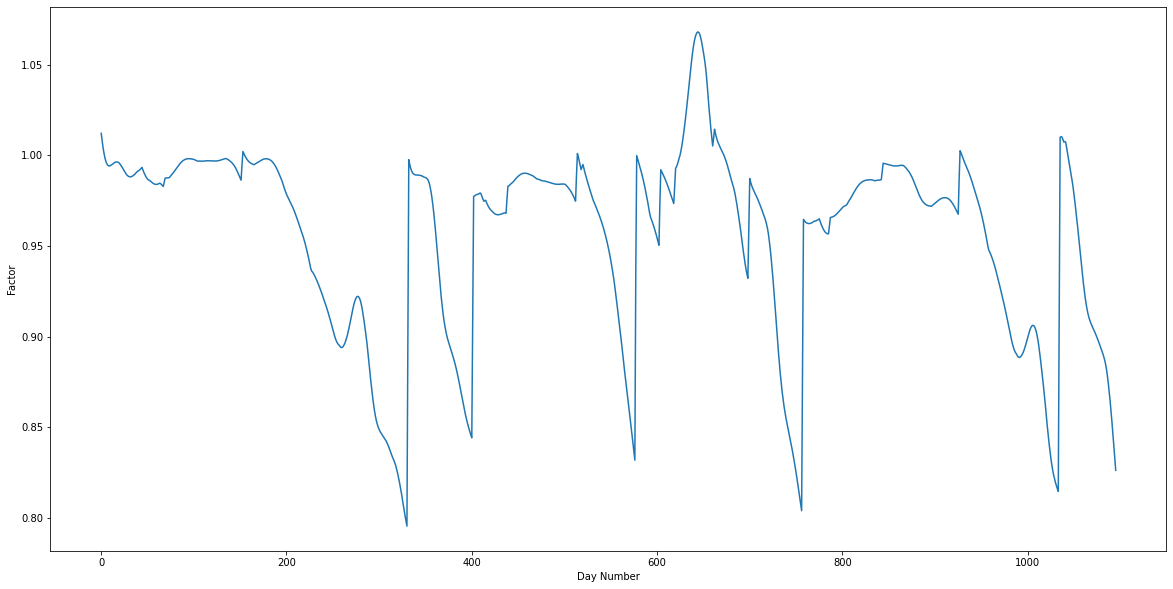

In [28]:
# Normalised power
norm_power = downsample_dataframe(sdf).Power.to_numpy() / downsample_dataframe(cs_df).Power.to_numpy()

_, ax = plt.subplots(figsize=(20,10))
ax.plot(norm_power)
plt.xlabel('Day Number')
plt.ylabel('Factor')

In [29]:
# Fit a line to the normalised power
rd, _ = np.polyfit(np.arange(len(norm_power)), norm_power, deg = 1)
print(f"Predicted degradation is {rd*365*100:0.3f}%/year, while the actual degradation is {actual_deg*100:0.3f}%/year")

Predicted degradation is -1.120%/year, while the actual degradation is -0.969%/year


# A signal from the soil and weather dataset 

In [30]:
# Load the data
index           = 2
path_to_zip_pkl = '../data/raw/synthetic_soil_weather.zip'
df              = import_df_from_zip_pkl(path_to_zip_pkl, index=index, verbose=True)

# Load the actual degradation rate
df_info = import_df_info_from_zip("../data/raw/synthetic_soil_weather.zip", verbose=True)
actual_deg = df_info.Degradation_rate_linear.iloc[1]


importing synthetic_soil_weather/synthetic_soil_weather_003.pkl

time for importing dataframe: 0.88 seconds
Found the following dataset info-files  ['synthetic_soil_weather/synthetic_soil_weather_info.csv']

importing synthetic_soil_weather/synthetic_soil_weather_info.csv



In [31]:
df.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-07:00,-1.0,0.0,-8.1,4.4,1.0,0.99999,1,0
2015-01-01 00:01:00-07:00,-1.0,0.0,-8.0,4.3,1.0,0.99999,1,1
2015-01-01 00:02:00-07:00,-1.0,0.0,-7.8,4.1,1.0,0.99999,1,2
2015-01-01 00:03:00-07:00,-1.0,0.0,-7.7,4.0,1.0,0.99999,1,3
2015-01-01 00:04:00-07:00,-1.0,0.0,-7.6,4.1,1.0,0.99999,1,4


In [32]:
signal_2d = make_2d(df[df.index.year <= 2017], key="Power", trim_start=False, trim_end=False)
signal_2d.shape

scsf = IterativeFitting(signal_2d)
scsf.execute(is_degradation_calculated=False)
clear_sky_signals = scsf.clear_sky_signals()

obtaining weights
obtaining initial value of component r0
Starting at Objective: 8.455e+08, f1: 4.826e+06, f2: 6.970e+01, f3: 6.271e+08, f4: 2.136e+08
    Minimizing left matrix
    Minimizing right matrix
Minimize R status: infeasible
Starting over and reversing minimization order.
obtaining initial value of component r0
    Minimizing right matrix
    Minimizing left matrix
1 - Objective: 5.628e+06, f1: 5.451e+06, f2: 8.059e+02, f3: 1.765e+05, f4: 7.048e-05
Caution: residuals increased
    Minimizing right matrix
    Minimizing left matrix
2 - Objective: 3.512e+06, f1: 3.320e+06, f2: 3.756e+02, f3: 1.915e+05, f4: 1.072e-05
    Minimizing right matrix
    Minimizing left matrix
3 - Objective: 3.377e+06, f1: 3.181e+06, f2: 3.380e+02, f3: 1.965e+05, f4: 4.163e-05
    Minimizing right matrix
    Minimizing left matrix
4 - Objective: 3.356e+06, f1: 3.156e+06, f2: 3.307e+02, f3: 1.994e+05, f4: 3.046e-05
    Minimizing right matrix
    Minimizing left matrix
5 - Objective: 3.348e+06, f1: 3.

Text(0, 0.5, 'Power (kW)')

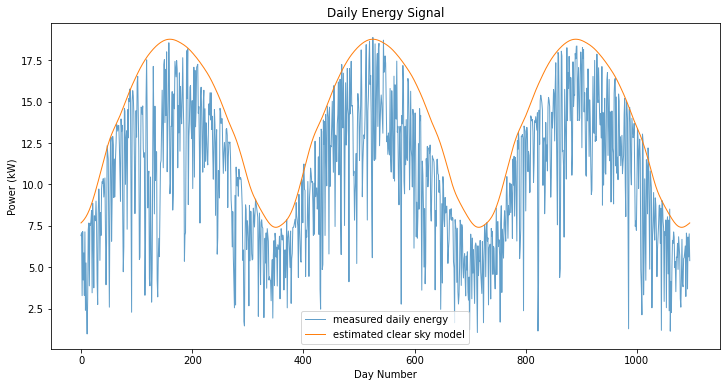

In [33]:
scsf.plot_energy(show_clear=True, show_days=False, scale_power=True)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

In [34]:
sdf = df[df.index.year <= 2017]
cs_df = pd.DataFrame(index = sdf.index)
cs_df['Power'] = np.reshape(np.transpose(clear_sky_signals), 1440*1096)
cs_df['minute_of_day'] = cs_df.index.hour * 60 + cs_df.index.minute
cs_df['Faults'] = np.nan
cs_df['Soiling'] = np.nan
cs_df['Degradation'] = np.nan

/home/julius/Aug20_Epri/.env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Text(0, 0.5, 'Power (kW)')

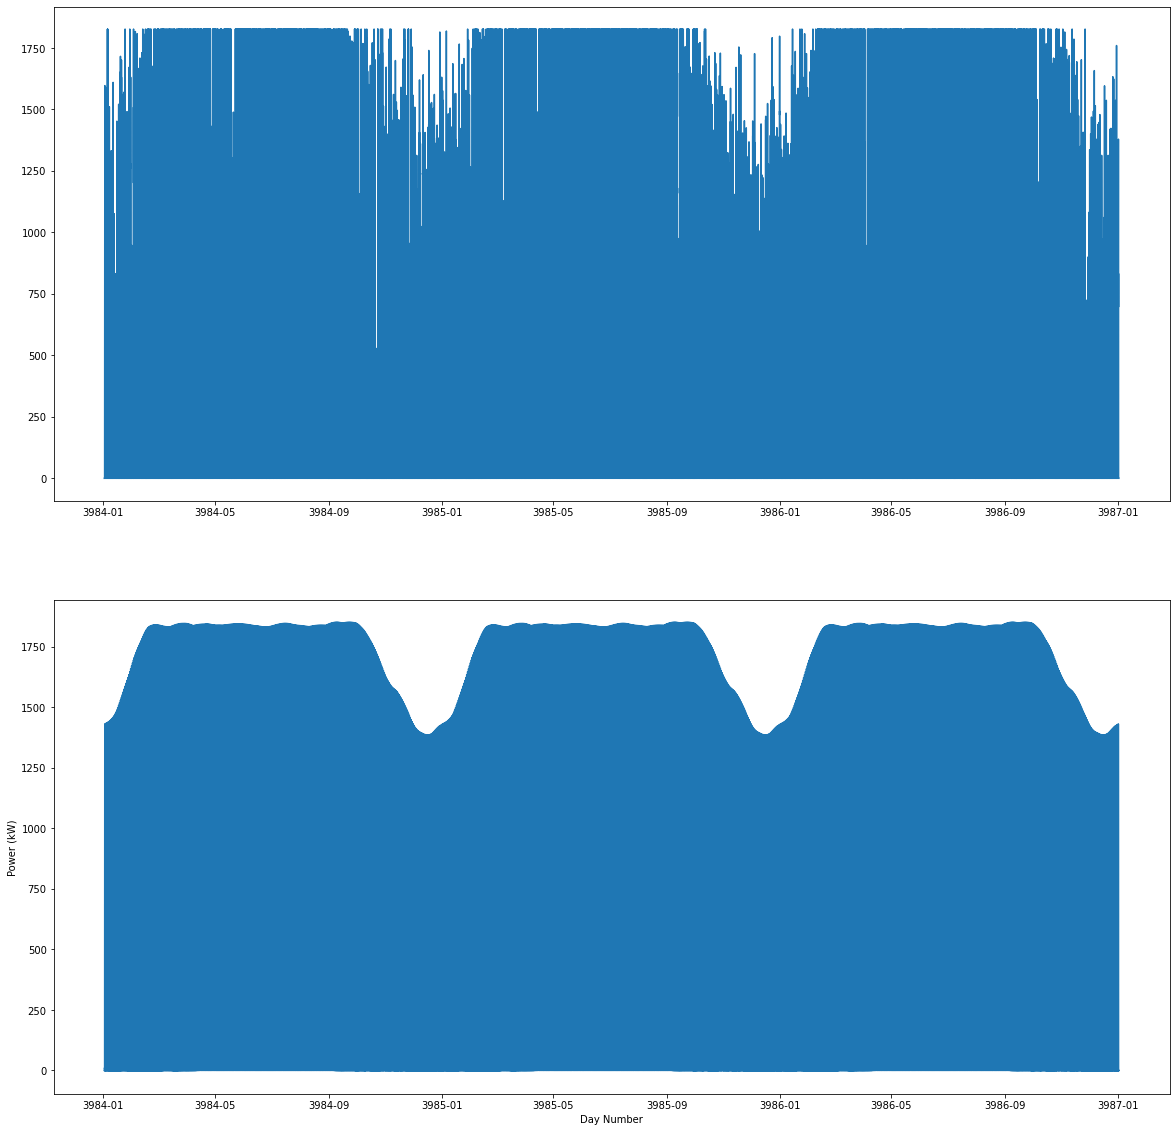

In [35]:
_, axs = plt.subplots(2, 1, figsize=(20, 20))

axs[0].plot(sdf.Power)
axs[1].plot(cs_df.Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Compare the two signals using our downsampling with and without removal of data.

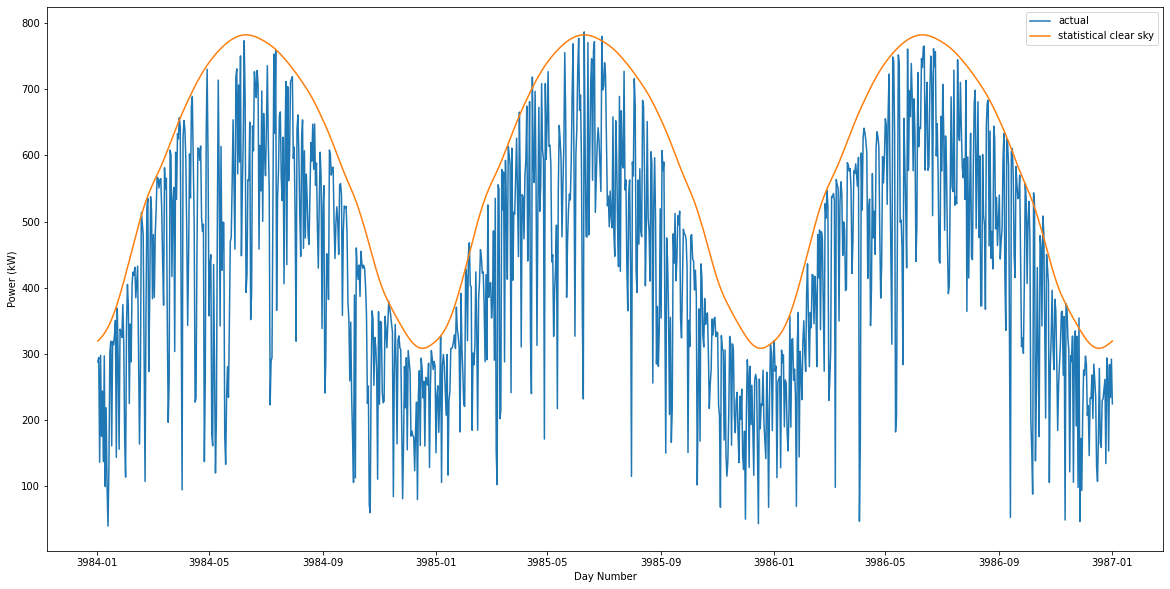

In [36]:
# Without clipping removal
_, ax = plt.subplots(figsize=(20, 10))

ax.plot(downsample_dataframe(sdf).Power, label = "actual")
ax.plot(downsample_dataframe(cs_df).Power, label = "statistical clear sky")
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')
plt.legend()

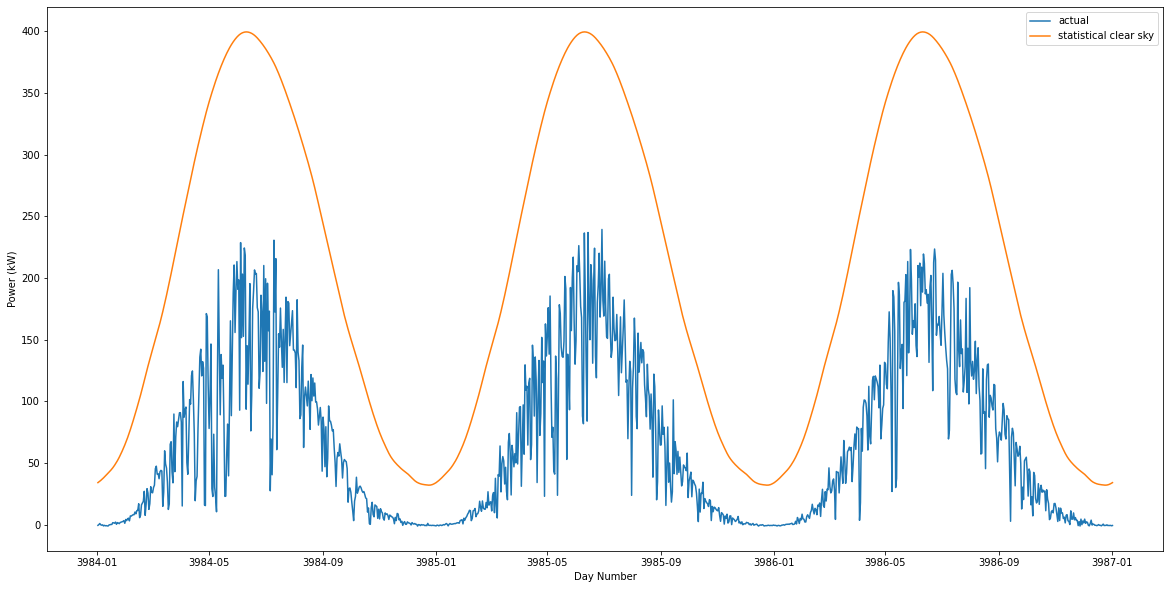

In [37]:
# With clipping removal
sdf_processed = remove_clipping_with_universal_window(sdf, max_power=1800)
sdf_processed = downsample_dataframe(sdf_processed)
cs_df_processed = remove_clipping_with_universal_window(cs_df, max_power=1800)
cs_df_processed = downsample_dataframe(cs_df_processed)

_, ax = plt.subplots(figsize=(20, 10))

ax.plot(sdf_processed.Power, label = "actual")
ax.plot(cs_df_processed.Power, label = "statistical clear sky")
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')
plt.legend()

Finally, let's consider the normalised power signal (without removal of clipping)

Text(0, 0.5, 'Factor')

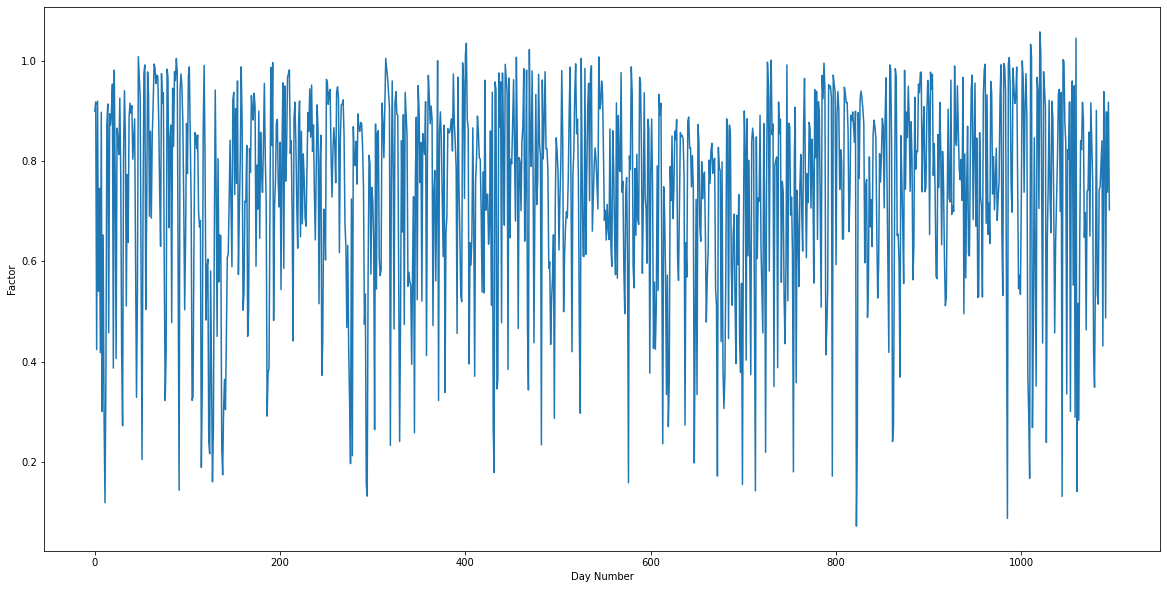

In [38]:
# Normalised power
norm_power = downsample_dataframe(sdf).Power.to_numpy() / downsample_dataframe(cs_df).Power.to_numpy()

_, ax = plt.subplots(figsize=(20,10))
ax.plot(norm_power)
plt.xlabel('Day Number')
plt.ylabel('Factor')

In [39]:
# Fit a line to the normalised power
rd, _ = np.polyfit(np.arange(len(norm_power)), norm_power, deg = 1)
print(f"Predicted degradation is {rd*365*100:0.3f}%/year, while the actual degradation is {actual_deg*100:0.3f}%/year")

Predicted degradation is 0.692%/year, while the actual degradation is -0.718%/year
